## Подготовка данных

Добавим в стандартный датасет Iris 20 случайных признаков с разными распределениями. Таким образом, мы сможем отследить качесвто и важность использования метода главных компонент.

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import time
import warnings

warnings.filterwarnings("ignore")

iris = load_iris()
X_base = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

np.random.seed(42)
random_features = pd.DataFrame()

for i in range(5):
    random_features[f'normal_{i+1}'] = np.random.normal(0, 1, size=X_base.shape[0])
    random_features[f'uniform_{i+1}'] = np.random.uniform(0, 1, size=X_base.shape[0])
    random_features[f'exponential_{i+1}'] = np.random.exponential(1.0, size=X_base.shape[0])
    random_features[f'lognormal_{i+1}'] = np.random.lognormal(0, 1, size=X_base.shape[0])

X_combined = pd.concat([X_base, random_features], axis=1)

scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

X_train, X_test, y_train, y_test = train_test_split(X_combined_scaled, y, test_size=0.3, random_state=42)

Напишим функция для обучения, предсказания и снятия метрик модели многослойного перцептрона.

In [22]:
def evaluate_model(X_train, X_test, y_train, y_test):
    model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=300, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        'Training Time (s)': training_time,
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred_test)
    }

    return metrics


Результаты до использования метода главных компонент

In [23]:
from IPython.display import display, Markdown

def display_metrics(metrics, title="Метрики"):
    metrics_str = f"### {title}\n"
    for key, value in metrics.items():
        metrics_str += f"- **{key}**: {value}\n"
    display(Markdown(metrics_str))

original_metrics = evaluate_model(X_train, X_test, y_train, y_test)
display_metrics(original_metrics, title="Метрики до применения PCA")

### Метрики до применения PCA
- **Training Time (s)**: 0.21388936042785645
- **Train Accuracy**: 0.9428571428571428
- **Test Accuracy**: 0.6666666666666666


In [24]:
from PCA import PCA
pca = PCA(X_train)
N = 3
X_train_pca, eigenvalues, eigenvectors = pca.pca_qr(n_components=N)
X_test_pca = (X_test @ eigenvectors[:, :N])
pca_metrics = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)
display_metrics(pca_metrics, title="Метрики после применения PCA")



### Метрики после применения PCA
- **Training Time (s)**: 0.15533018112182617
- **Train Accuracy**: 0.8571428571428571
- **Test Accuracy**: 0.9333333333333333


In [25]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Explained Variance Ratio': explained_variance_ratio
})
explained_variance_df

,Principal Component,Explained Variance Ratio
0,PC1,0.472263
1,PC2,0.267068
2,PC3,0.260669


Выводим матрицу главных компонент (матрица преобразований)

In [26]:
transformation_matrix = eigenvectors[:, :N]
transformation_df = pd.DataFrame(transformation_matrix, columns=[f'PC{i+1}' for i in range(N)])
transformation_df

,PC1,PC2,PC3
0,0.464565,0.135077,-0.127321
1,-0.223676,0.299983,-0.132076
2,0.538601,0.018657,-0.044357
3,0.525704,0.007475,-0.022145
4,0.097005,-0.030243,-0.040315
5,-0.066188,0.284138,-0.120238
6,0.077659,-0.018984,0.400533
7,-0.113455,-0.148481,0.029557
8,-0.128960,0.030254,0.031536
9,0.111911,-0.208447,0.225070


## Подбор числа компонент

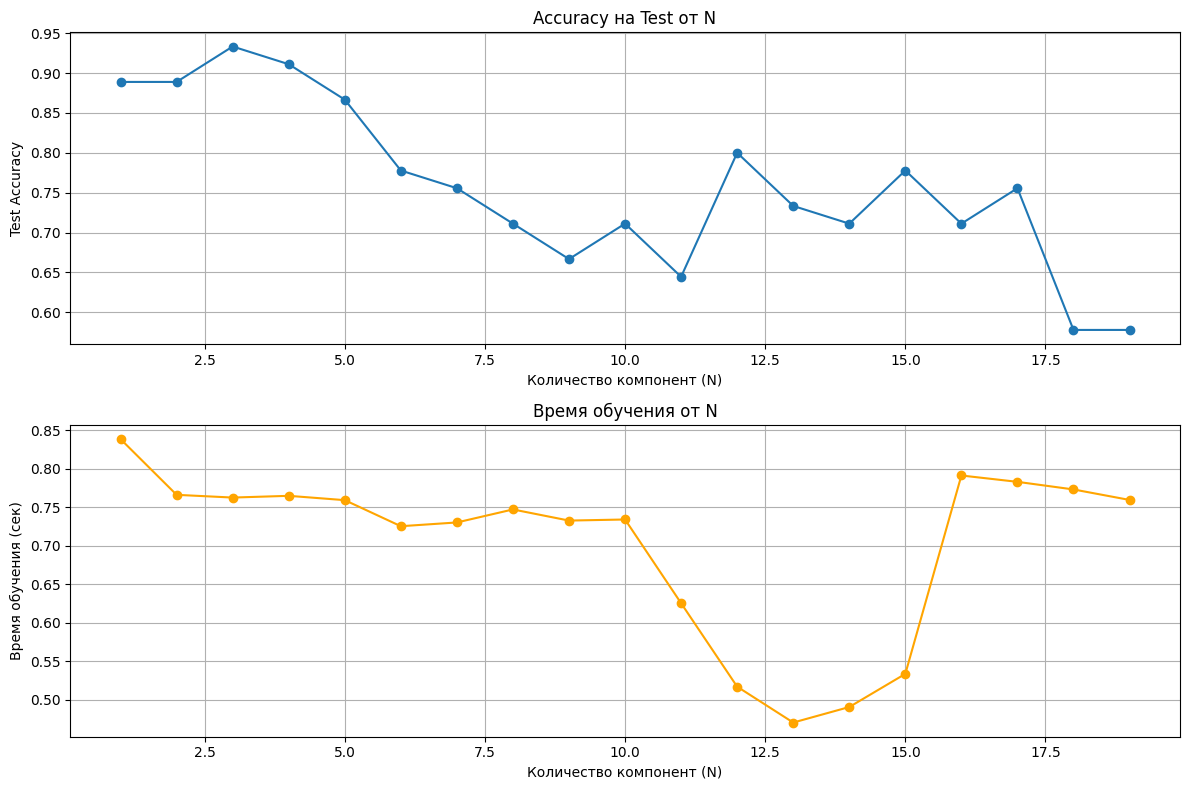

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import time

N_values = range(1, 20)
test_accuracies = []
training_times = []

for N in N_values:
    pca = PCA(X_train)
    start_time = time.time()
    X_train_pca, eigenvalues, eigenvectors = pca.pca_qr(n_components=N)
    training_time = time.time() - start_time

    X_test_pca = (X_test @ eigenvectors[:, :N])
    pca_metrics = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)

    test_accuracies.append(pca_metrics['Test Accuracy'])
    training_times.append(training_time)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(N_values, test_accuracies, marker='o')
plt.title('Accuracy на Test от N')
plt.xlabel('Количество компонент (N)')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(N_values, training_times, marker='o', color='orange')
plt.title('Время обучения от N')
plt.xlabel('Количество компонент (N)')
plt.ylabel('Время обучения (сек)')
plt.grid(True)

plt.tight_layout()
plt.show()



Достигаем наибольшей accuracy на тесте при числе компонент n=3 

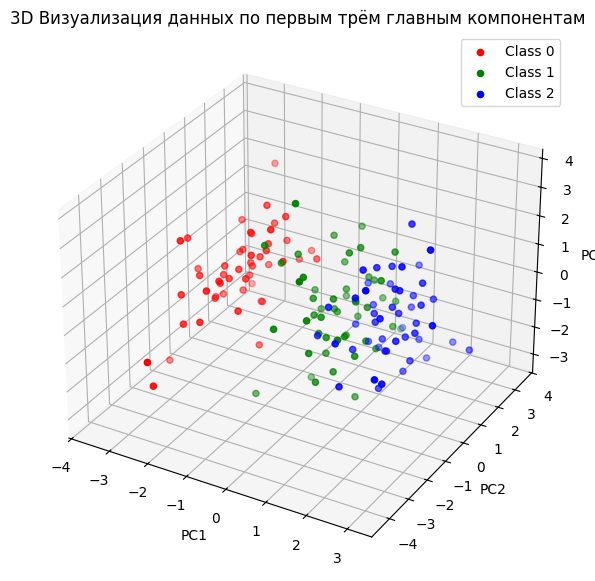

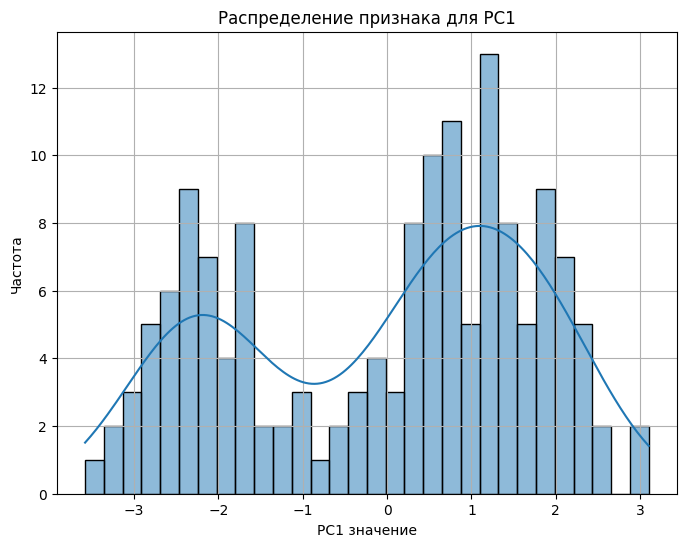

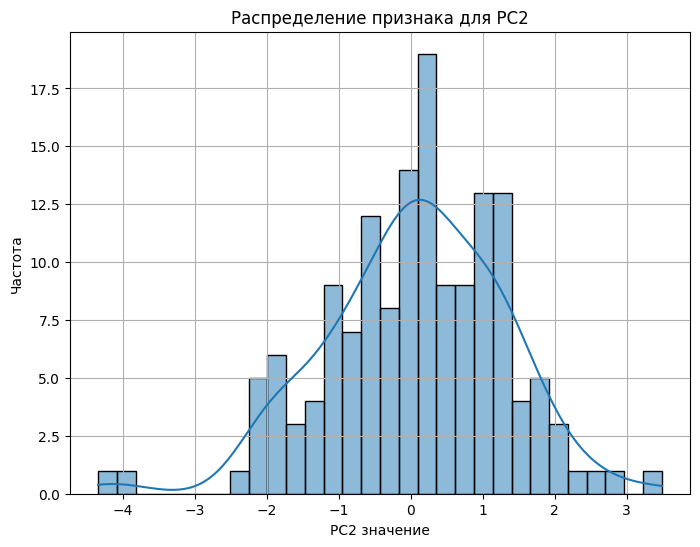

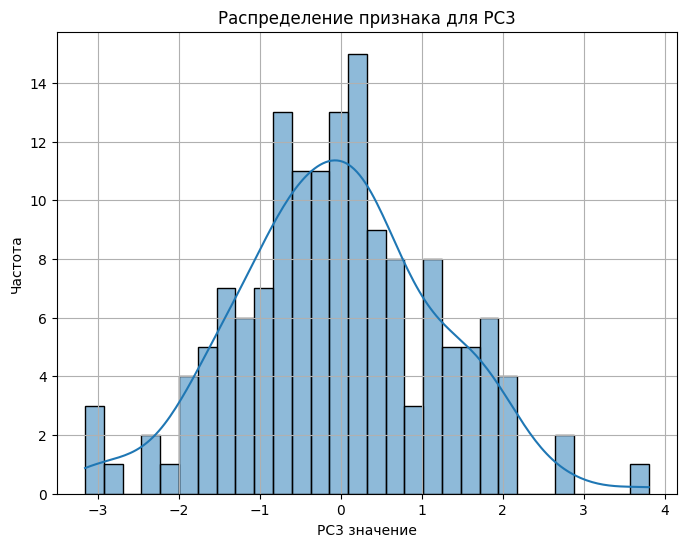

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(X_train)
X_train_pca, eigenvalues, eigenvectors = pca.pca_qr(n_components=3)
X_test_pca = (X_test @ eigenvectors[:, :3])

X_pca_combined = np.vstack([X_train_pca, X_test_pca])
y_combined = np.hstack([y_train, y_test])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
labels = np.unique(y_combined)

for label, color in zip(labels, colors):
    ax.scatter(
        X_pca_combined[y_combined == label, 0],
        X_pca_combined[y_combined == label, 1],
        X_pca_combined[y_combined == label, 2],
        label=f'Class {label}',
        color=color
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Визуализация данных по первым трём главным компонентам')
ax.legend()
plt.show()


for i in range(3):
    plt.figure(figsize=(8, 6))
    sns.histplot(X_pca_combined[:, i], bins=30, kde=True)
    plt.title(f'Распределение признака для PC{i+1}')
    plt.xlabel(f'PC{i+1} значение')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()



Не сложно заметить, что данные на общем графике неплохо разделимы между собой, а распределение каждого признака близко к нормальному

## Сравнение метрик до и после

In [29]:
original_metrics = evaluate_model(X_train, X_test, y_train, y_test)
display_metrics(original_metrics, title="Метрики до применения PCA")

### Метрики до применения PCA
- **Training Time (s)**: 0.2303311824798584
- **Train Accuracy**: 0.9428571428571428
- **Test Accuracy**: 0.6666666666666666


In [30]:
pca = PCA(X_train)
N = 3
X_train_pca, eigenvalues, eigenvectors = pca.pca_qr(n_components=N)
X_test_pca = (X_test @ eigenvectors[:, :N])
pca_metrics = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)
display_metrics(pca_metrics, title="Метрики после применения PCA")

### Метрики после применения PCA
- **Training Time (s)**: 0.15358376502990723
- **Train Accuracy**: 0.8571428571428571
- **Test Accuracy**: 0.9333333333333333


Нетудно заметить, что метрики на тестовой выборке значительно улучшились, а время обучения также сущетсвенно сократилось